In [1]:
import numpy as np # linear algebra
import pandas as pd
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers

In [2]:
batch_size = 64;
epochs = 100;
latent_dim = 256;  
num_samples = 10000; 
data_path = "pol.txt";

In [3]:
input_texts = [];
target_texts = [];
input_characters = set();
target_characters = set();
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n");
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t");
    target_text = "\t" + target_text + "\n";
    input_texts.append(input_text);
    target_texts.append(target_text);
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char);
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char);

In [4]:
input_characters = sorted(list(input_characters));
target_characters = sorted(list(target_characters));
num_encoder_tokens = len(input_characters);
num_decoder_tokens = len(target_characters);
max_encoder_seq_length = max([len(txt) for txt in input_texts]);
max_decoder_seq_length = max([len(txt) for txt in target_texts]);

In [5]:
print("Samples :", len(input_texts));
print("Number of unique source tokens:", num_encoder_tokens);
print("Unique input tokens", num_decoder_tokens);
print("Maximum length of the input sequence:", max_encoder_seq_length);
print("Maximum length of the outnput sequence:", max_decoder_seq_length);

Samples : 10000
Number of unique source tokens: 73
Unique input tokens 91
Maximum length of the input sequence: 21
Maximum length of the outnput sequence: 58


In [6]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)]);
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)]);

encoder_input_data = np.zeros( (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32");
decoder_input_data = np.zeros( (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32");
decoder_target_data = np.zeros( (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32");

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0;
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0;
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.0;
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0;
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0;
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0;

# Build model

In [7]:
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens));
encoder = keras.layers.LSTM(latent_dim, return_state=True);
encoder_outputs, state_h, state_c = encoder(encoder_inputs);

encoder_states = [state_h, state_c];

decoder_inputs = keras.Input(shape=(None, num_decoder_tokens));

decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True);
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states);
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="sigmoid");
decoder_outputs = decoder_dense(decoder_outputs);

model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs);


# Learn model

In [8]:
model.compile(optimizer='rmsprop',loss="categorical_crossentropy", metrics=["accuracy"]);
model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size=batch_size, epochs=epochs, validation_split=0.2);
#Save model
model.save("s2s");

Epoch 1/100
125/125 [==============================] - 55s 381ms/step - loss: 1.2677 - accuracy: 0.7133 - val_loss: 1.2783 - val_accuracy: 0.6667
Epoch 2/100
125/125 [==============================] - 44s 350ms/step - loss: 0.9166 - accuracy: 0.7598 - val_loss: 1.0348 - val_accuracy: 0.7197
Epoch 3/100
125/125 [==============================] - 43s 347ms/step - loss: 0.7689 - accuracy: 0.7895 - val_loss: 0.8994 - val_accuracy: 0.7483
Epoch 4/100
125/125 [==============================] - 43s 347ms/step - loss: 0.6830 - accuracy: 0.8089 - val_loss: 0.8480 - val_accuracy: 0.7590
Epoch 5/100
125/125 [==============================] - 51s 407ms/step - loss: 0.6450 - accuracy: 0.8166 - val_loss: 0.7961 - val_accuracy: 0.7727
Epoch 6/100
125/125 [==============================] - 53s 423ms/step - loss: 0.6045 - accuracy: 0.8267 - val_loss: 0.7715 - val_accuracy: 0.7792
Epoch 7/100
125/125 [==============================] - 52s 417ms/step - loss: 0.5759 - accuracy: 0.8348 - val_loss: 0.7427 -

Epoch 57/100
125/125 [==============================] - 50s 401ms/step - loss: 0.1338 - accuracy: 0.9619 - val_loss: 0.7810 - val_accuracy: 0.8301
Epoch 58/100
125/125 [==============================] - 46s 364ms/step - loss: 0.1303 - accuracy: 0.9632 - val_loss: 0.7914 - val_accuracy: 0.8300
Epoch 59/100
125/125 [==============================] - 39s 313ms/step - loss: 0.1272 - accuracy: 0.9638 - val_loss: 0.7988 - val_accuracy: 0.8299
Epoch 60/100
125/125 [==============================] - 42s 335ms/step - loss: 0.1242 - accuracy: 0.9646 - val_loss: 0.8083 - val_accuracy: 0.8292
Epoch 61/100
125/125 [==============================] - 39s 311ms/step - loss: 0.1215 - accuracy: 0.9655 - val_loss: 0.8151 - val_accuracy: 0.8300
Epoch 62/100
125/125 [==============================] - 39s 315ms/step - loss: 0.1186 - accuracy: 0.9663 - val_loss: 0.8170 - val_accuracy: 0.8301
Epoch 63/100
125/125 [==============================] - 39s 312ms/step - loss: 0.1161 - accuracy: 0.9671 - val_loss: 0

INFO:tensorflow:Assets written to: s2s\assets


INFO:tensorflow:Assets written to: s2s\assets


In [9]:
model = keras.models.load_model("s2s");

encoder_inputs = model.input[0]; # input 1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output;  # lstm_1
encoder_states = [state_h_enc, state_c_enc];
encoder_model = keras.Model(encoder_inputs, encoder_states);

In [10]:
decoder_inputs = model.input[1]; # input 2
decoder_state_input_h = keras.Input(shape=(latent_dim,));
decoder_state_input_c = keras.Input(shape=(latent_dim,));
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c];
decoder_lstm = model.layers[3];
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs);
decoder_states = [state_h_dec, state_c_dec];
decoder_dense = model.layers[4];
decoder_outputs = decoder_dense(decoder_outputs);
decoder_model = keras.Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states);

In [11]:
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items());
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items());

# Using and generation

In [12]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1, num_decoder_tokens));
    target_seq[0, 0, target_token_index["\t"]] = 1.0;
    stop_condition = False;
    decoded_sentence = "";
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value);

        sampled_token_index = np.argmax(output_tokens[0, -1, :]);
        sampled_char = reverse_target_char_index[sampled_token_index];
        decoded_sentence += sampled_char;
 
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True;

        target_seq = np.zeros((1, 1, num_decoder_tokens));
        target_seq[0, 0, sampled_token_index] = 1.0;

        states_value = [h, c];
    return decoded_sentence;

In [13]:
for seq_index in range(10):
    input_seq = encoder_input_data[seq_index : seq_index + 1];
    decoded_sentence = decode_sequence(input_seq);
    print("----------------")
    print("Input sentence", input_texts[seq_index]);
    print("Output sentence", decoded_sentence);

----------------
Input sentence Go.
Output sentence Idź.

----------------
Input sentence Hi.
Output sentence Cześć.

----------------
Input sentence Run!
Output sentence Uciekaj!

----------------
Input sentence Run.
Output sentence Uciekaj.

----------------
Input sentence Run.
Output sentence Uciekaj.

----------------
Input sentence Who?
Output sentence Kto?

----------------
Input sentence Wow!
Output sentence Łał!

----------------
Input sentence Wow!
Output sentence Łał!

----------------
Input sentence Duck!
Output sentence Unik!

----------------
Input sentence Fire!
Output sentence Strzelaj!



# Task 2

In [14]:
from keras.datasets import fashion_mnist

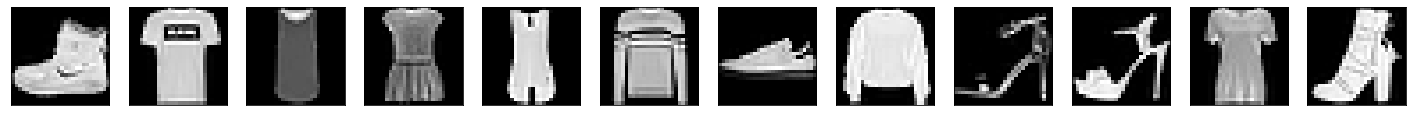

In [15]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data();
n = 12  

plt.figure(figsize=(25, 10));
for i in range(n):
    ax = plt.subplot(1, n, i + 1);
    plt.imshow(x_train[i]);
    plt.gray();
    ax.get_xaxis().set_visible(False);
    ax.get_yaxis().set_visible(False);
 
plt.show()

In [16]:
print(x_train.shape[0], ' - amout of samples');
print('Image form: ', x_train[0].shape);
print('Amount of classes: ', len(set(y_train)));

60000  - amout of samples
Image form:  (28, 28)
Amount of classes:  10


In [17]:
dim = 28*28; 
x_train = x_train.reshape(60000, dim);
x_train = (x_train.astype(np.float32) - 127.5) / 127.5  # normilization [-1, 1]

In [18]:
adam = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5) #optimizer
latent_dim = 100;

# Discriminator

In [19]:
def build_discriminator(): 
    model =  keras.Sequential()
    
    model.add(layers.Dense(1000, input_dim=dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)));
    model.add(layers.LeakyReLU(alpha=0.2));
    model.add(layers.Dropout(0.3));
     
    model.add(layers.Dense(512));
    model.add(layers.LeakyReLU(alpha=0.2));
    model.add(layers.Dropout(0.3));

    model.add(layers.Dense(256));
    model.add(layers.LeakyReLU(alpha=0.2));
    model.add(layers.Dropout(0.3));

    model.add(layers.Dense(150));
    model.add(layers.LeakyReLU(alpha=0.2));
    model.add(layers.Dropout(0.3));

    model.add(layers.Dense(1, activation='sigmoid'));
    model.compile(loss='binary_crossentropy', optimizer=adam);
    return model;

# Generator

In [20]:
def build_generator():
    model =  keras.Sequential()
    model.add(layers.Dense(150, input_dim=latent_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)));
    model.add(layers.LeakyReLU(alpha=0.2));

    model.add(layers.Dense(256));
    model.add(layers.LeakyReLU(alpha=0.2));

    model.add(layers.Dense(512));
    model.add(layers.LeakyReLU(alpha=0.2));
    
    model.add(layers.Dense(1000));
    model.add(layers.LeakyReLU(alpha=0.2));

    model.add(layers.Dense(dim, activation='tanh'));

    model.compile(loss='binary_crossentropy', optimizer=adam);
    return model;

In [21]:
discriminator = build_discriminator();
generator = build_generator();

discriminator.trainable = False;
gan_input = keras.Input(shape=(latent_dim,));
x = generator(gan_input);
gan_output = discriminator(x);
gan = keras.Model(inputs=gan_input, outputs=gan_output);
gan.compile(loss='binary_crossentropy', optimizer=adam);

In [22]:
def plot_generated_images(epoch, generator):
    num_of_images = 7;
    noise = np.random.normal(0, 1, size=[num_of_images, latent_dim]);
    generated_images=generator.predict(noise).reshape(num_of_images, 28, 28);
    plt.figure();
    for i in range(num_of_images):
        plt.subplot(1, 7, i+1);
        plt.imshow(generated_images[i], cmap = 'gray');
        plt.axis('off');
        plt.tight_layout();
    plt.show()

epoch:  0


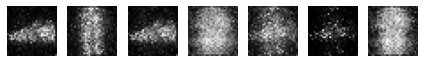

In [ ]:
discrim_losses = [];

def train_model(epochs, batch_size):
    num_batches = int(x_train.shape[0]/batch_size);
    for ep in range(epochs+1):
        for i in range(num_batches):
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim]);
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)];
            
            # Generate fake images
            generated_images = generator.predict(noise);
            X = np.concatenate([image_batch, generated_images]);

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size);
            y_dis[:batch_size] = 0.9; 
            # Train discriminator
            discriminator.trainable = True;
            d_loss = discriminator.train_on_batch(X, y_dis);
            discrim_losses.append(d_loss);

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim]);
            y_gen = np.ones(batch_size);
            discriminator.trainable = False;
            gan.train_on_batch(noise, y_gen);
        if ep % 10 == 0:
            print('epoch: ', ep)
            plot_generated_images(ep, generator);
            
            
epochs = 100;
batch_size = 256;
train_model(epochs, batch_size);